In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Tuple, Dict
from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
from transformers import AutoTokenizer, AutoModel, TrainingArguments
from tqdm import tqdm
from typing import List, Tuple, Dict
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DATASETDIR = "./GptCloneDatasetDataframes/df_java_contrastive.csv"


In [ ]:
class GPTCloneDataset(Dataset):
    def __init__(
        self,
        df,
        batch_size: int = 32,
        tokenizer_name: str = "microsoft/codebert-base",
        max_length: int = 512,

    ):
        """

        """

        self.df = df
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.cached = {}  # Dictionary to store cached files

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        if idx in self.cached:
            return self.cached[idx]

        function_text_one ,function_text_two, label= self.df.iloc[idx]

        # Tokenize again with truncation
        tokens_code1 = self.tokenizer(
            function_text_one,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        tokens_code2 = self.tokenizer(
            function_text_two,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        label = torch.tensor(label, dtype=torch.long)

        self.cached[idx] = {
            'function_one_input_ids': tokens_code1['input_ids'].squeeze(0),
            'function_one_attention_mask': tokens_code1['attention_mask'].squeeze(0),
            'function_two_input_ids': tokens_code2['input_ids'].squeeze(0),
            'function_two_attention_mask': tokens_code2['attention_mask'].squeeze(0),
            'function_text_one':function_text_one,
            'function_text_two':function_text_two,
            'label' : label
        }
        # Squeeze the tensors to remove the extra dimension added by return_tensors="pt"
        return self.cached[idx]





In [ ]:

def get_dataloaders(
    batch_size: int = 4,
    num_workers=4,
    ):
    """
    Create train, validation, and test dataloaders along with the original datasets
    """
    df = pd.read_csv(DATASETDIR, index_col=  None)

    print(f"df loaded with {len(df)} rows and {df.columns} columns")

    # Split into train, validation, and test sets
    train_size = int(0.8 * len(df))
    val_size = int(0.05 * len(df))

    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    train_dataset = GPTCloneDataset(train_df)
    test_dataset = GPTCloneDataset(test_df)
    validation_dataset = GPTCloneDataset(val_df)
    Traindataloader = DataLoader( train_dataset,
    batch_size=batch_size,
    shuffle=True,)
    Testdataloader = DataLoader( test_dataset,
    batch_size=batch_size,
    shuffle=True,)
    validationDataloader = DataLoader( validation_dataset,
    batch_size=batch_size,
    shuffle=True,)


    return Traindataloader,validationDataloader, Testdataloader



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class CodeCloneDetectionModel(nn.Module):
    def __init__(
        self,
        model_name: str = "microsoft/codebert-base",
        embedding_dim: int = 768,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        hidden_size = self.model.config.hidden_size
        # Final projection to embedding dimension
        self.final_projection = nn.Sequential(
            nn.Linear(hidden_size, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
    def preprocess_code(self, code_text: str) -> dict:
        inputs = self.tokenizer(
            code_text,
            return_tensors="pt",
            max_length=512,
            padding="max_length",
            truncation=True
        )

        return {k: v.to(self.device) for k, v in inputs.items()}


    def encode(self, input_ids, attention_mask):
        # Get BERT embeddings
        with torch.no_grad():  # Ensure BERT layers don't compute gradients
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Get CLS token
        x = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
        # Final projection
        embedding = self.final_projection(x)  # [batch_size, embedding_dim]
        return F.normalize(embedding, p=2, dim=1)

    def forward(self, function1_ids, function1_mask, function2_ids, function2_mask):
        emb1 = self.encode(function1_ids, function1_mask)
        emb2 = self.encode(function2_ids, function2_mask)
        return emb1, emb2







In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.margin = margin

    def forward(self, emb1: torch.Tensor, emb2: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # Normalize embeddings
        emb1 = F.normalize(emb1, p=2, dim=1)
        emb2 = F.normalize(emb2, p=2, dim=1)

        # Calculate euclidean distance
        distance = torch.norm(emb1 - emb2, dim=1)

        # Scale distances to increase separation
        distance = distance * 2  # Optional scaling factor

        pos_loss = labels * distance.pow(2)
        neg_loss = (1 - labels) * torch.pow(torch.clamp(self.margin - distance, min=0), 2)

        loss = torch.mean(pos_loss + neg_loss)
        return loss


In [ ]:
class CosineTripletLoss(nn.Module):
    def __init__(self, margin=0.5, lambda_reg=0.01):
        super(CosineTripletLoss, self).__init__()
        self.margin = margin
        self.lambda_reg = lambda_reg

    def forward(self, anchor, positive, negative):

        # Compute cosine similarities
        pos_sim = F.cosine_similarity(anchor, positive, dim=1)
        neg_sim = F.cosine_similarity(anchor, negative, dim=1)

        # Basic triplet loss
        triplet_loss = torch.relu(neg_sim - pos_sim + self.margin)

        # Add regularization to push negative pairs further apart
        neg_push = torch.relu(neg_sim + 0.1)  # Penalize negative similarities above -0.1

        # Add regularization to ensure embeddings are well-distributed
        diversity_reg = (torch.mean(torch.matmul(anchor, anchor.t())) +
                        torch.mean(torch.matmul(positive, positive.t())) +
                        torch.mean(torch.matmul(negative, negative.t())))

        # Combine losses
        total_loss = triplet_loss.mean() + self.lambda_reg * neg_push.mean() + \
                    self.lambda_reg * torch.relu(diversity_reg - 1.5)

        return total_loss


In [ ]:
import json
import shutil

def save_model(model, tokenizer, save_dir='saved_model', base_path=None):
    """
    Save the model, tokenizer, and configuration
    """
    print("saving best model")
    if base_path is None:
        base_path = Path('/content/drive/MyDrive')

    # Create full save path
    save_path = base_path / save_dir

    # Create temporary local directory for saving
    local_save_path = Path('/content/temp_save')
    local_save_path.mkdir(parents=True, exist_ok=True)

    # Save model state locally first
    torch.save(model.state_dict(), local_save_path / 'modelsiamese.pth')

    # Save tokenizer locally
    tokenizer.save_pretrained(local_save_path)

    # Save configuration
    config = {
        'model_name': model.model.config._name_or_path,
        'hidden_size': model.model.config.hidden_size,
        'max_length': 512
    }

    with open(local_save_path / 'config.json', 'w') as f:
        json.dump(config, f)

    # Create the save directory in Google Drive
    save_path.mkdir(parents=True, exist_ok=True)

    # Copy everything from local to Drive
    shutil.copytree(local_save_path, save_path, dirs_exist_ok=True)

    # Clean up local files
    shutil.rmtree(local_save_path)

    print(f"Model saved successfully to Google Drive at: {save_path}")
    return save_path


def save_checkpoint(model, tokenizer, epoch, optimizer, loss, save_dir='checkpoints'):
    """
    Save a training checkpoint including optimizer state and epoch
    """
    save_path = Path('/content/drive/MyDrive') / save_dir
    save_path.mkdir(parents=True, exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # Save checkpoint
    torch.save(checkpoint, save_path / f'checkpoint_epoch_{epoch}.pt')

    # Save latest model and tokenizer
    save_model(model, tokenizer, save_dir=f'{save_dir}/latest')



In [ ]:

class CodeClonePredictor:
    def __init__(self, model, tokenizer, device=None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.model = model.to(self.device)
        self.tokenizer = tokenizer
        self.model.eval()

    def get_embedding(self, code_text):
        tokens = self.tokenizer(
            code_text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = tokens['input_ids'].to(self.device)
        attention_mask = tokens['attention_mask'].to(self.device)

        with torch.no_grad():
            embedding = self.model.encode(input_ids, attention_mask)

        return F.normalize(embedding, p=2, dim=1)

    def get_embedding_from_tokens(self, input_ids,attention_mask):

        with torch.no_grad():
            embedding = self.model.encode(input_ids, attention_mask)
        return F.normalize(embedding, p=2, dim=1)

    def compare_codes(self, code1, code2):
        """Compare two code snippets and return their similarity score"""

        emb1 = self.get_embedding(code1)
        emb2 = self.get_embedding(code2)
        similarity = F.cosine_similarity(emb1, emb2).item()
        return similarity



    def find_clones(self, query_code, code_list, threshold=0.8):
        """Find potential clones of query_code in code_list"""
        query_emb = self.get_embedding(query_code)
        results = []

        for idx, code in enumerate(code_list):
            code_emb = self.get_embedding(code)
            similarity = F.cosine_similarity(query_emb, code_emb).item()

            if similarity >= threshold:
                results.append({
                    'index': idx,
                    'similarity': similarity,
                    'code': code
                })

        # Sort by similarity in descending order
        results.sort(key=lambda x: x['similarity'], reverse=True)
        return results


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score


def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, num_epochs=5):
    training_history = []
    min_val_loss = float('inf')
    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

    # Store similarities, labels, and epochs for plotting
    similarity_data = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        print(f"Epoch {epoch + 1}:")

        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()

            # Move data to device
            function_one_input_ids = batch['function_one_input_ids'].to(device)
            function_one_attention_mask = batch['function_one_attention_mask'].to(device)
            function_two_input_ids = batch['function_two_input_ids'].to(device)
            function_two_attention_mask = batch['function_two_attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            emb_one, emb_two = model(
                function_one_input_ids, function_one_attention_mask,
                function_two_input_ids, function_two_attention_mask,
            )

            # Calculate loss
            loss = criterion(emb_one, emb_two, labels)
            total_train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        print("training loss", total_train_loss / len(train_loader))

        # Validation phase
        print("\nEvaluating on validation set...")
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Move data to device
                function_one_input_ids = batch['function_one_input_ids'].to(device)
                function_one_attention_mask = batch['function_one_attention_mask'].to(device)
                function_two_input_ids = batch['function_two_input_ids'].to(device)
                function_two_attention_mask = batch['function_two_attention_mask'].to(device)
                labels = batch['label'].to(device)
                # Forward pass
                emb_one, emb_two = model(
                    function_one_input_ids, function_one_attention_mask,
                    function_two_input_ids, function_two_attention_mask,
                )

                # Calculate loss
                loss = criterion(emb_one, emb_two, labels)
                total_val_loss += loss.item()



                # Get similarity scores for the validation set

                predictor = CodeClonePredictor(model, tokenizer)
                for i in range(len(batch['function_one_input_ids'])):
                    code1 = batch['function_text_one'][i]
                    code2 = batch['function_text_two'][i]
                    similarity = predictor.compare_codes(code1, code2)
                    similarity_data.append({
                        'epoch': epoch + 1,
                        'similarity': similarity,
                        'label': batch['label'][i]
                    })

        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            save_model(model, tokenizer, save_dir='saved_model')

        auc = calculate_auc(similarity_data, epoch)
        print(f"val Loss: {avg_val_loss:.4f} AUC {auc}\n")
        plot_similarity_scatter(similarity_data)
    # Scatter Plot
    plot_similarity_scatter(similarity_data)

    return training_history, avg_val_loss , similarity_data



def calculate_auc(similarity_data, epoch=None):
    """Calculate AUC for a specific epoch or all data if epoch is None"""
    df = pd.DataFrame(similarity_data)

    if epoch is not None:
        df = df[df['epoch'] == epoch+1]
    # Get the true labels and similarity scores
    y_true = [f.item() for f in df['label']]
    y_scores = df['similarity']
    # Calculate ROC AUC
    auc = roc_auc_score(y_true, y_scores)
    return auc

def plot_similarity_scatter(similarity_data, testing=False):
    df = pd.DataFrame(similarity_data)
    jitter_strength = 0.2

    if not testing:
        df['epoch_jittered'] = df['epoch'] + np.random.uniform(-jitter_strength, jitter_strength, len(df))

        unique_epochs = sorted(df['epoch'].unique())
        aucs = []
        for e in unique_epochs:
            current_df = df[df['epoch'] == e]
            y_true = [f.item() for f in current_df['label']]
            y_scores = current_df['similarity']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append((e, auc))

        best_epoch, best_auc = max(aucs, key=lambda x: x[1])
        title = f"Similarity of Samples by Epoch (Best AUC: {best_auc:.3f} at Epoch {int(best_epoch)})"
    else:
        df['epoch_jittered'] = 1 + np.random.uniform(-jitter_strength, jitter_strength, len(df))
        auc = calculate_auc(similarity_data)
        title = f"Similarity (AUC: {auc:.3f})"


    plt.figure(figsize=(20, 10))

    # Plot points
    for label, color, marker in [(1, 'green', 'o'), (0, 'red', 'x')]:
        subset = df[df['label'] == label]
        plt.scatter(
            subset['epoch_jittered'],
            subset['similarity'],
            c=color,
            label=f'Clone={label}',
            alpha=0.7,
            marker=marker,
            s=40
        )

    plt.xlabel("Epoch")
    plt.ylabel("Similarity (0 to 1)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    similarity_data = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Move data to device
            function_one_input_ids = batch['function_one_input_ids'].to(device)
            function_one_attention_mask = batch['function_one_attention_mask'].to(device)
            function_two_input_ids = batch['function_two_input_ids'].to(device)
            function_two_attention_mask = batch['function_two_attention_mask'].to(device)
            labels = batch['label'].to(device)
            # Forward pass
            emb_one, emb_two = model(
                function_one_input_ids, function_one_attention_mask,
                function_two_input_ids, function_two_attention_mask,
            )

            # Get similarity scores for the validation set

            predictor = CodeClonePredictor(model, tokenizer)
            for i in range(len(batch['function_one_input_ids'])):
                code1 = batch['function_text_one'][i]
                code2 = batch['function_text_two'][i]
                label = batch['label'][i]
                similarity = predictor.compare_codes(code1, code2)
                similarity_data.append({
                    'similarity': similarity,
                    'label': label
                })

    # Scatter Plot
    plot_similarity_scatter(similarity_data, testing= True)

    return similarity_data


In [ ]:
from pathlib import Path
def load_model(save_dir='code_clone_model', base_path=None):
    """
    Load the saved model from Google Drive

    Args:
        save_dir: Directory name where the model is saved
        base_path: Base path in Google Drive (default is /content/drive/MyDrive)
    """
    if base_path is None:
        base_path = Path('/content/drive/MyDrive')

    save_path = base_path / save_dir

    # Verify that the save directory exists
    if not save_path.exists():
        raise FileNotFoundError(f"No saved model found at {save_path}")

    # Load configuration
    with open(save_path / 'config.json', 'r') as f:
        config = json.load(f)

    # Initialize model
    model = CodeCloneDetectionModel(model_name=config['model_name'])

    # Load model state
    model.load_state_dict(torch.load(save_path / 'modelsiamese.pth', weights_only=True))

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(save_path)

    print(f"Model loaded successfully from: {save_path}")
    return model, tokenizer, config



In [ ]:

def start_training(load_trained_model = False):
    Traindataloader,validationDataloader, Testdataloader  = get_dataloaders(
        batch_size=32,
        num_workers=16
    )

    print("working with cuda") if torch.cuda.is_available() else print("working with cpu")
    if load_trained_model:
        model, tokenizer, config = load_model('saved_model')
        model = model.to(device)
    else:
        model = CodeCloneDetectionModel().to(device)
        tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

    optimizer = optim.AdamW(model.parameters(), lr= 1e-3, weight_decay=1e-4)
    criterion = ContrastiveLoss(margin=1.0)

    training_history, avg_val_loss ,similarity_data = train_model(
        model,
        Traindataloader,
        validationDataloader,
        Testdataloader,
        optimizer,
        criterion,
        device,
        num_epochs=10
    )
    # Save the model after training
    save_model(model, tokenizer, save_dir='saved_model')
    return model, tokenizer ,training_history , similarity_data


df loaded with 23230 rows and Index(['function 1', 'function 2', 'clone'], dtype='object') columns
working with cuda
Epoch 1:


Training: 100%|██████████| 581/581 [04:15<00:00,  2.28it/s]


training loss 0.1613472887730024

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:37<00:00,  1.02s/it]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.1140 AUC 0.936638672918274



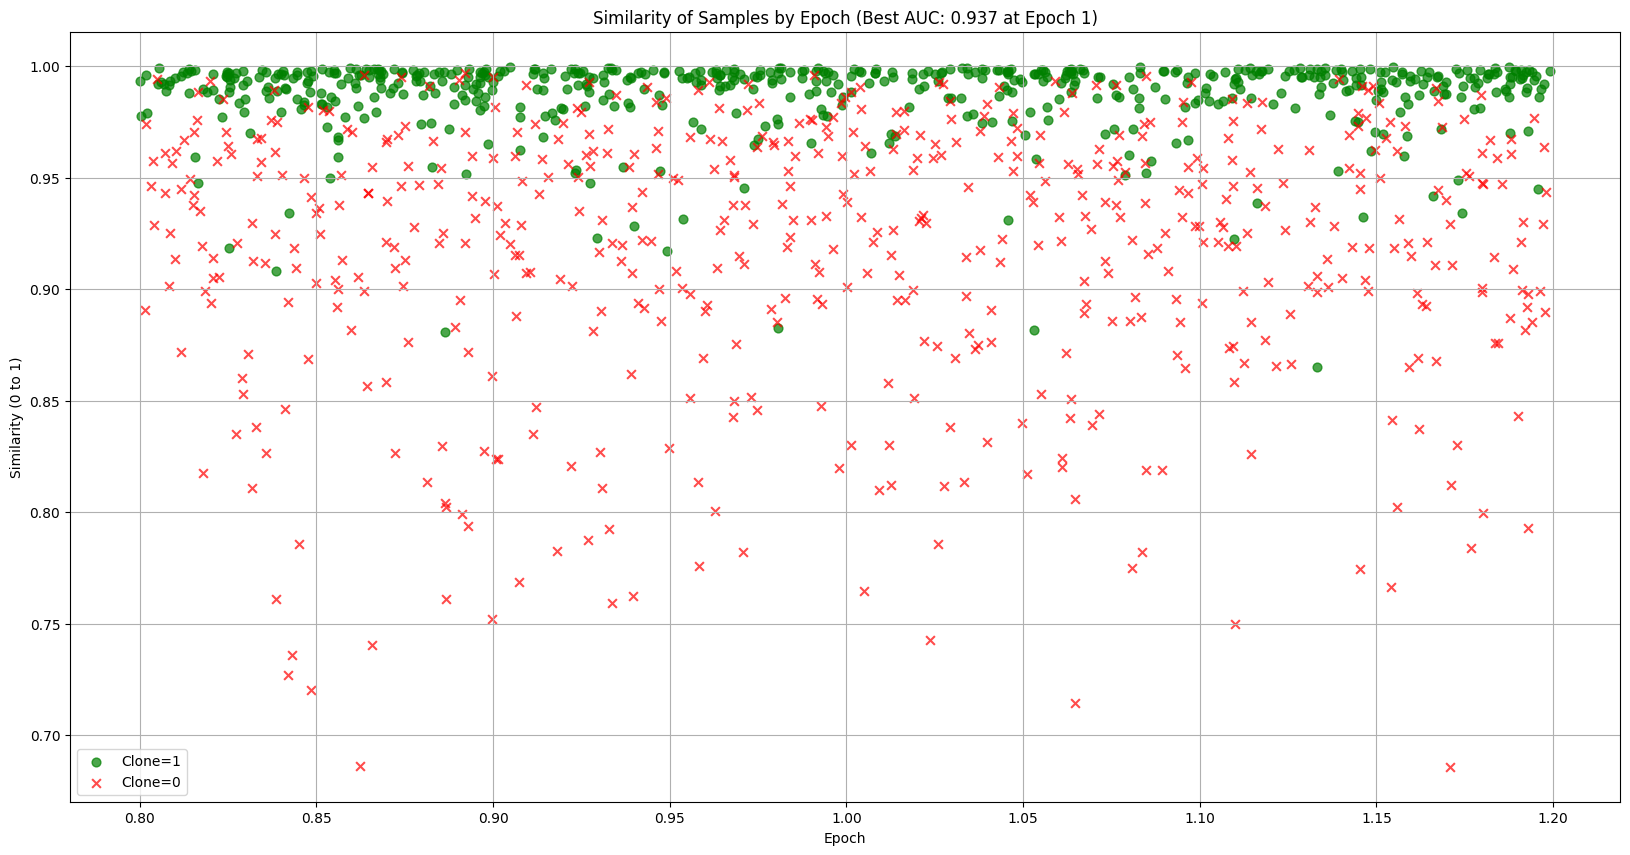

Epoch 2:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.1177622813045363

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.0948 AUC 0.9649074129028429



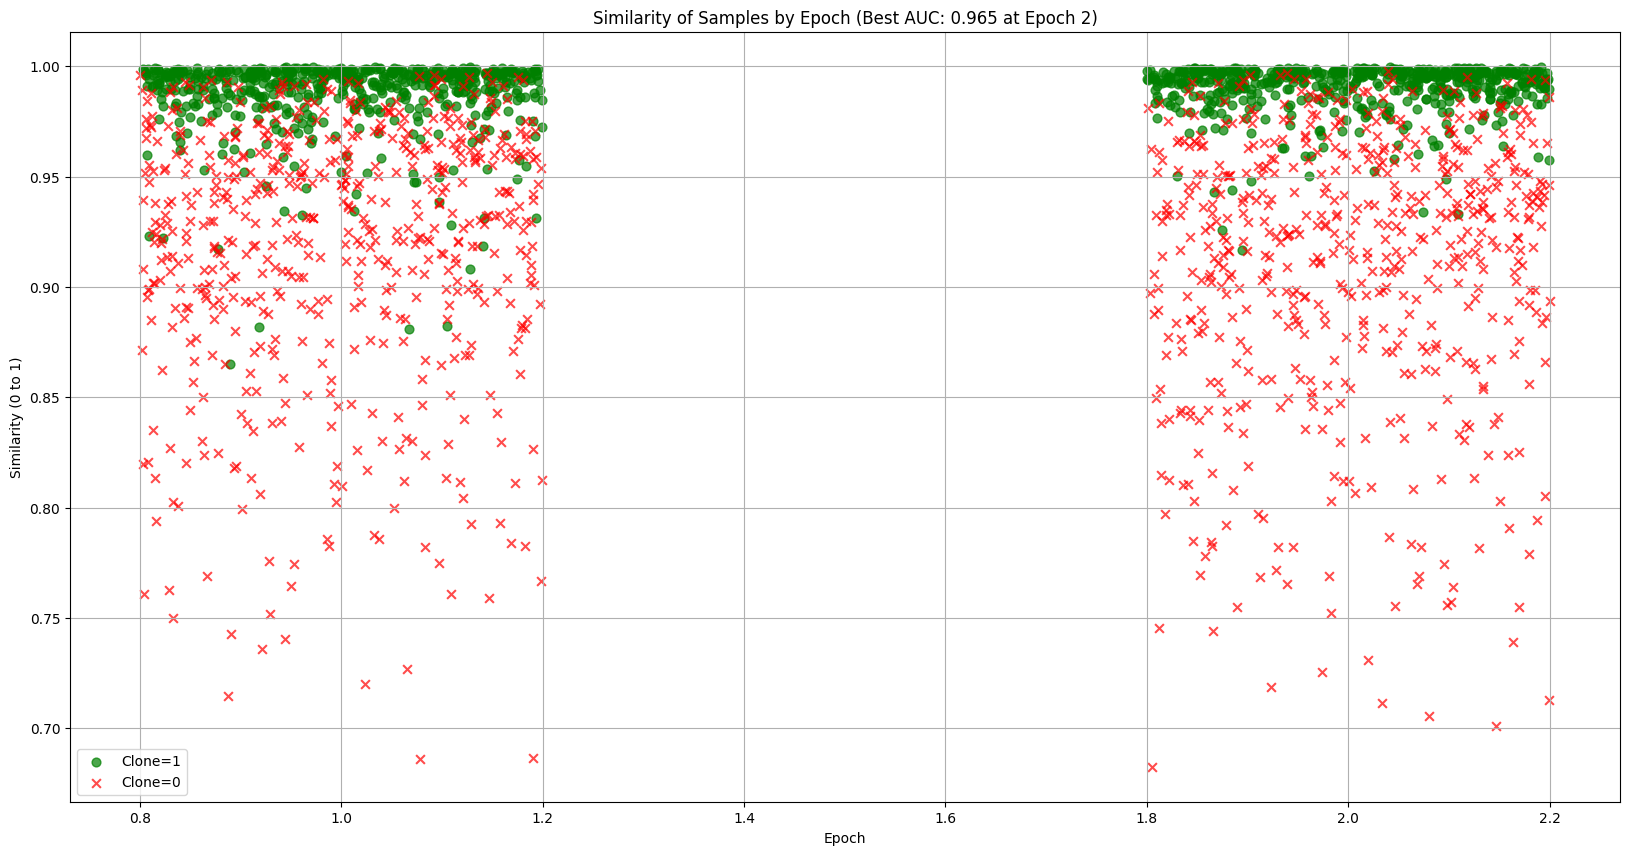

Epoch 3:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.11016704396003289

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.03it/s]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.0948 AUC 0.9623315923793697



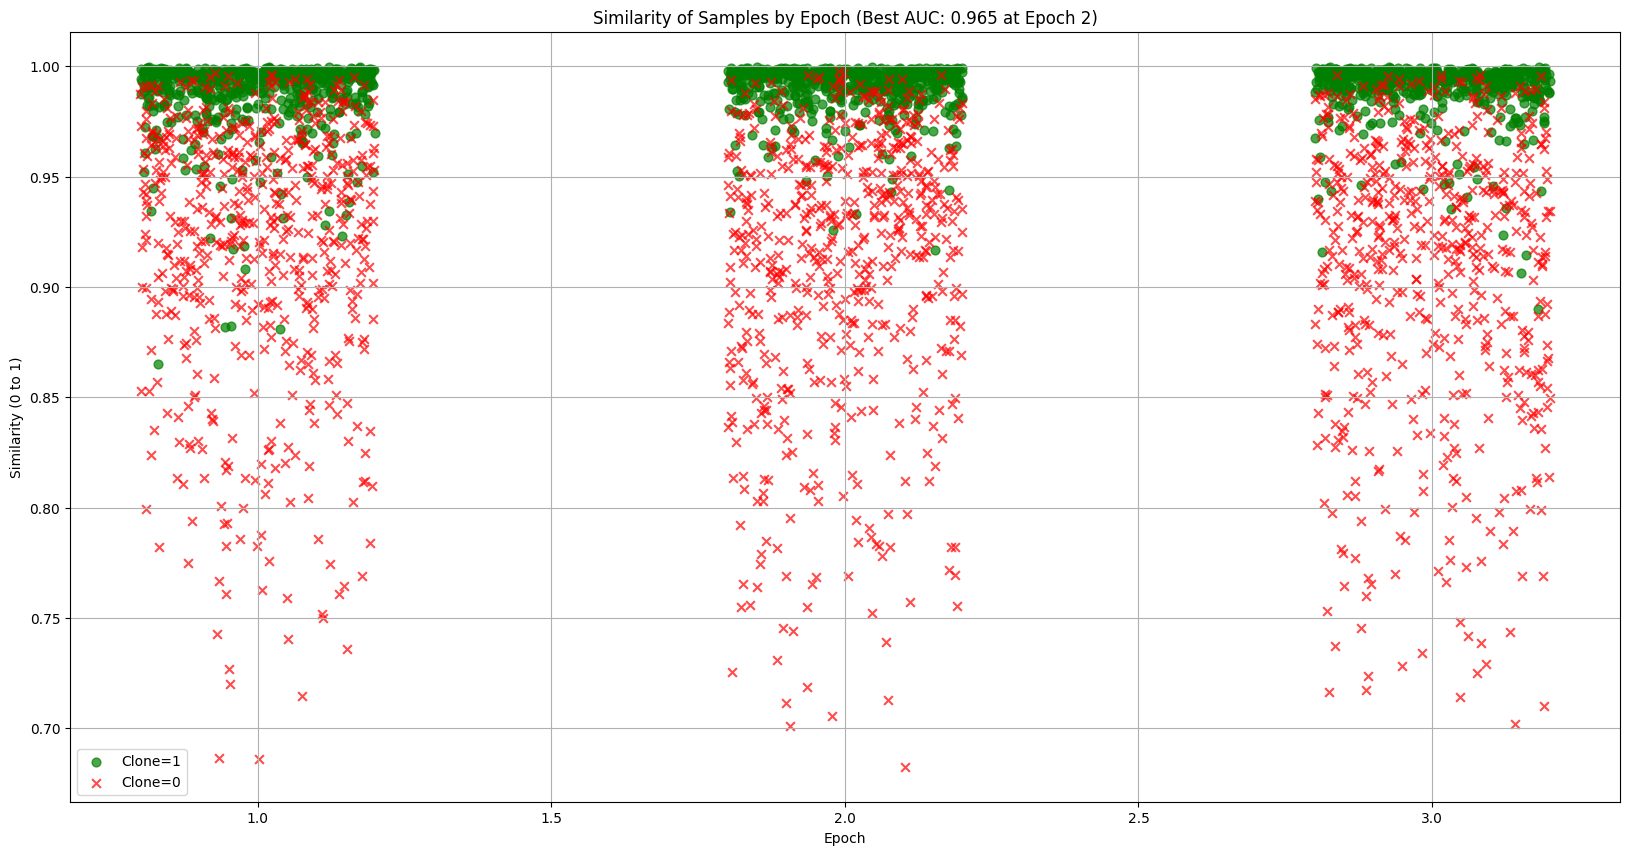

Epoch 4:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10698561404996813

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.0878 AUC 0.9697682355035908



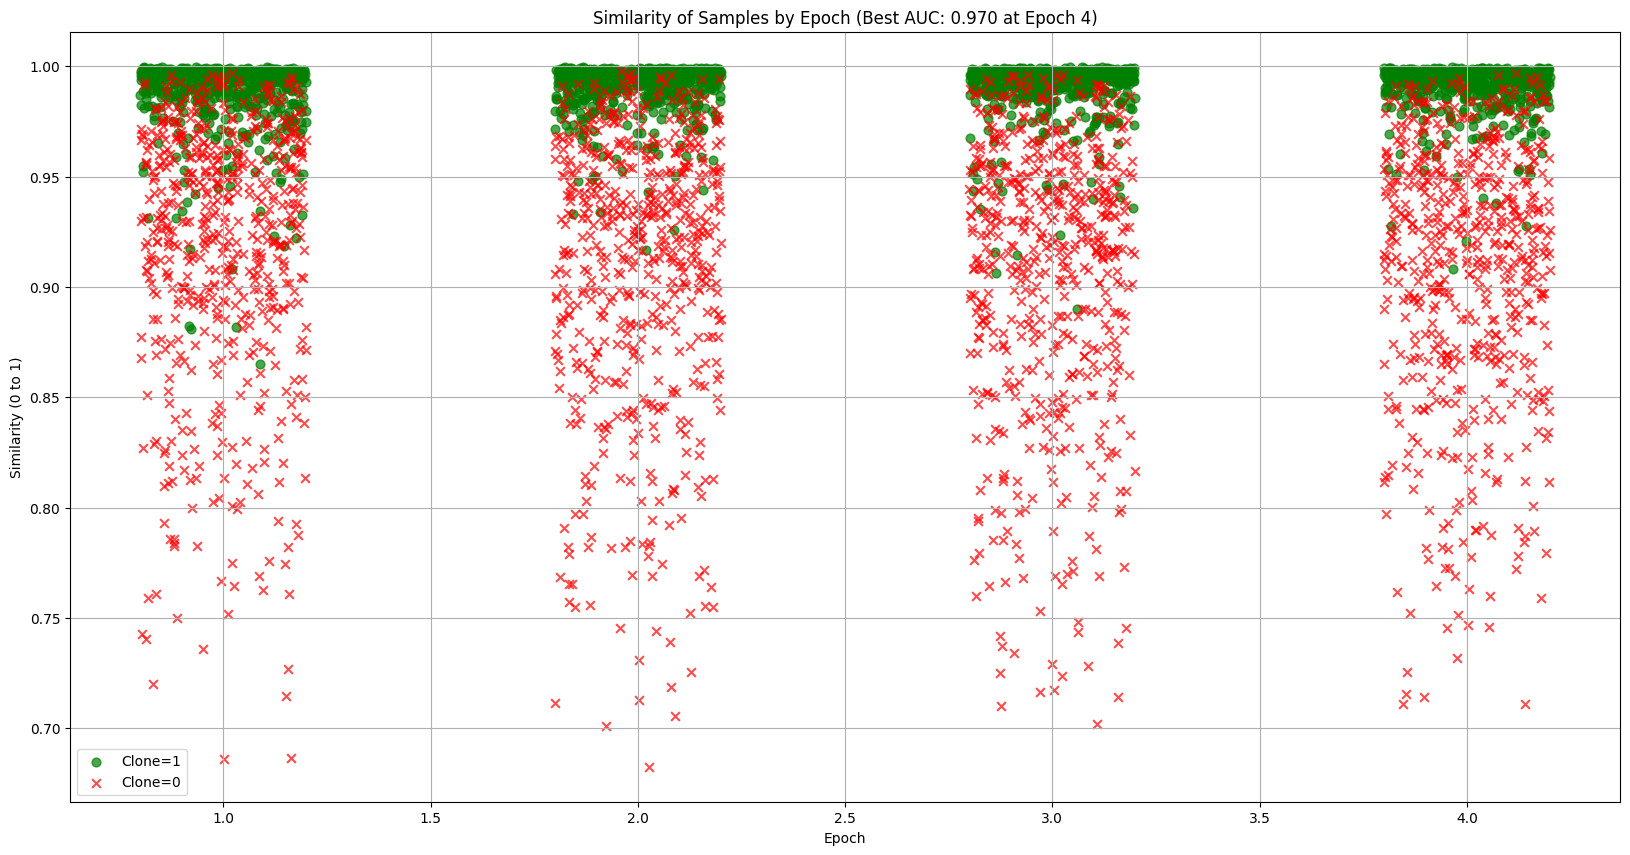

Epoch 5:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10664242311106696

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


val Loss: 0.0912 AUC 0.9684476823550359



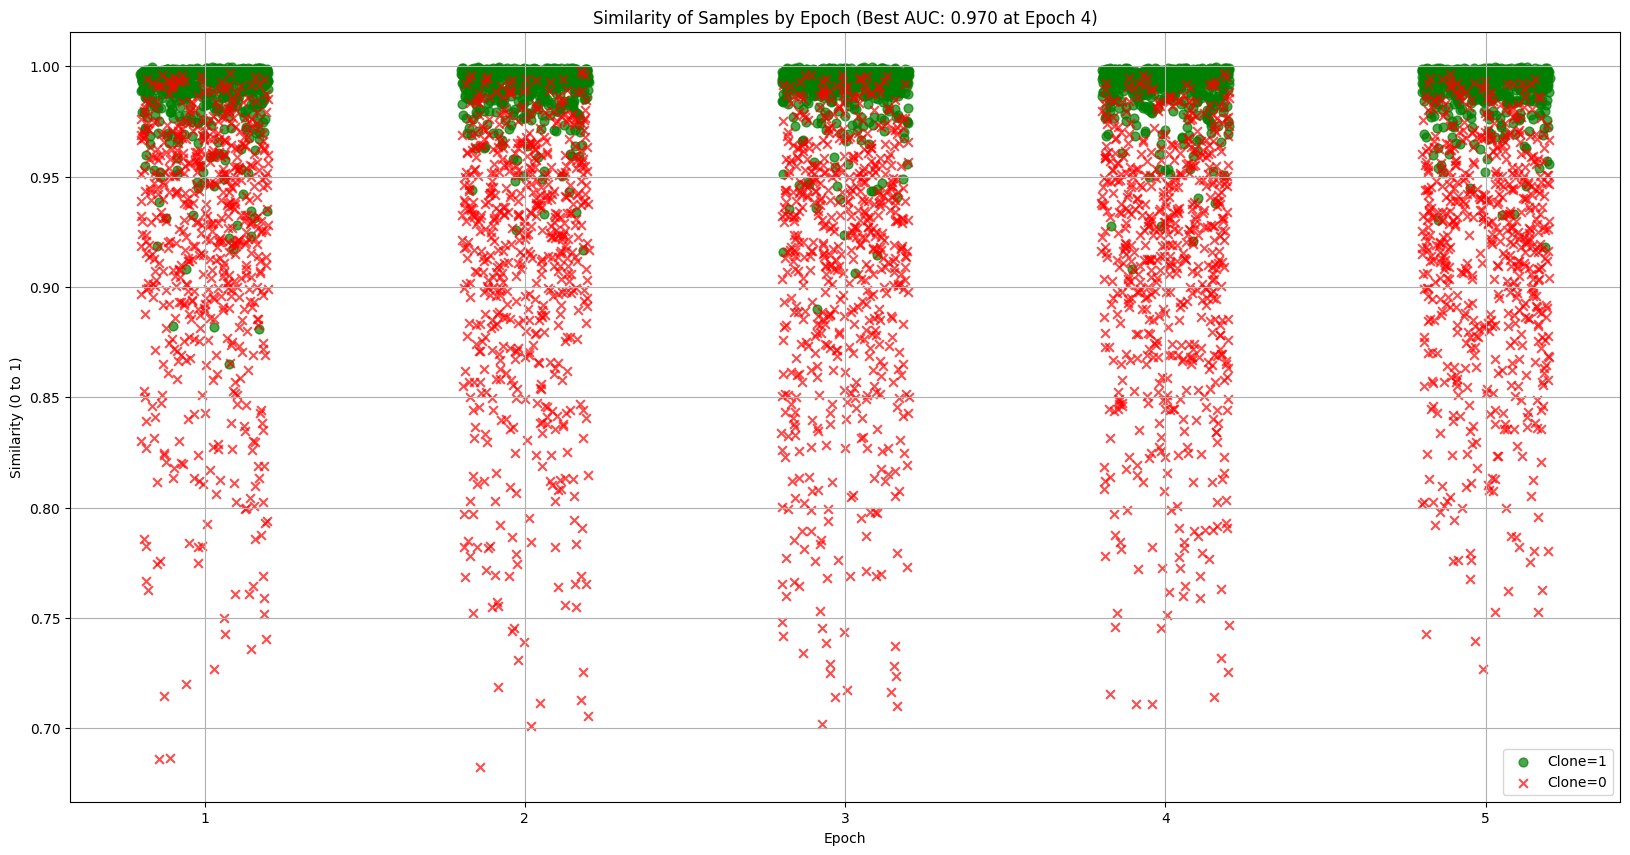

Epoch 6:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10543097067053675

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.0859 AUC 0.969088669950739



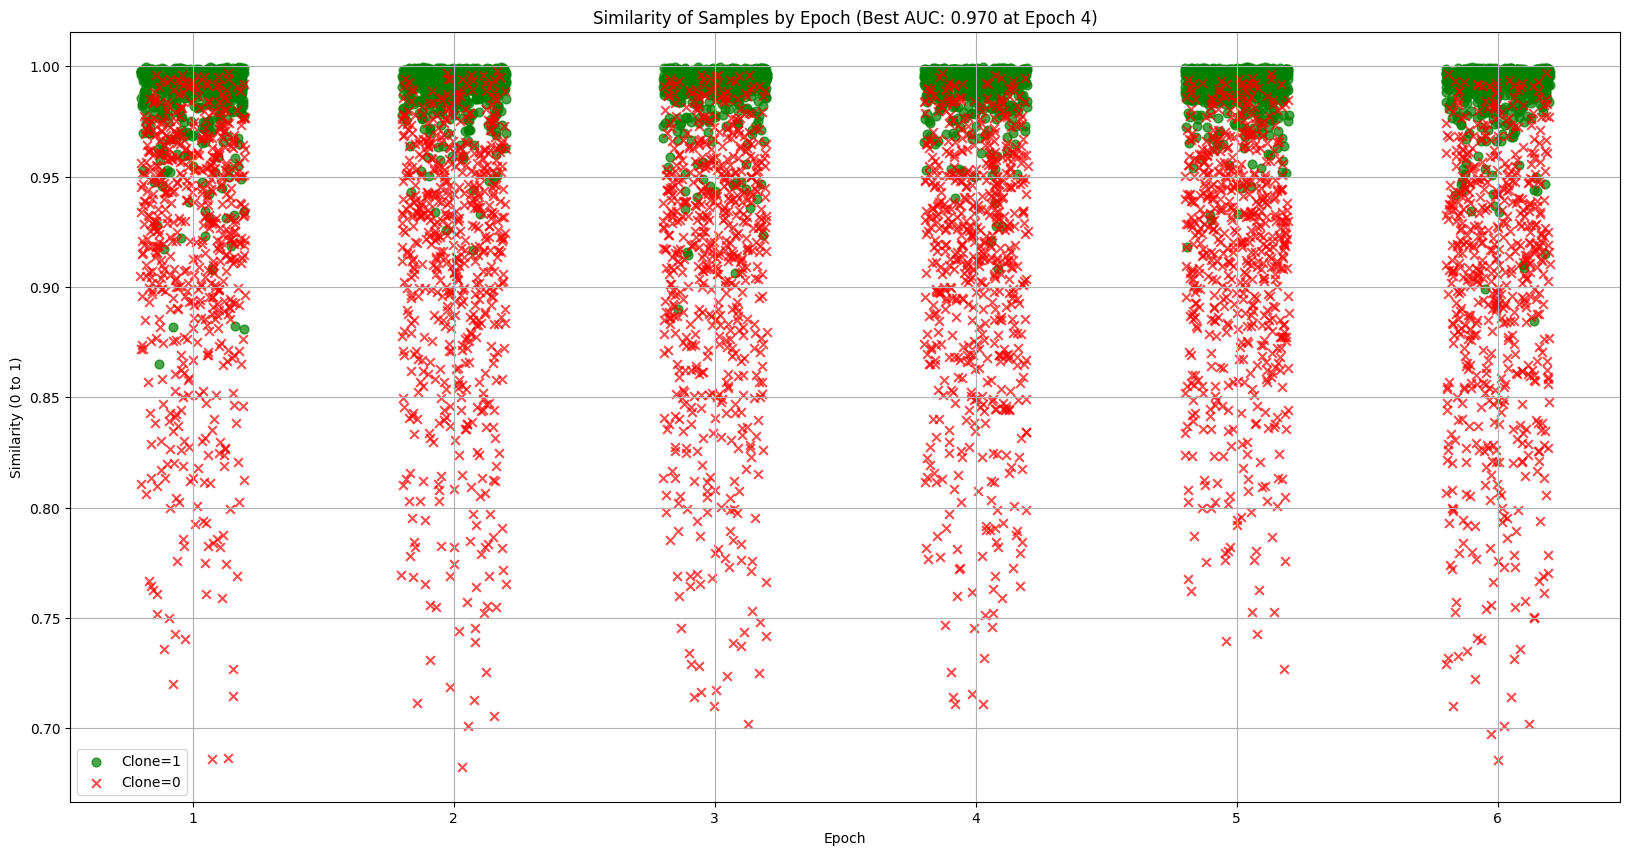

Epoch 7:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10423256042004657

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


val Loss: 0.0877 AUC 0.9688304943913586



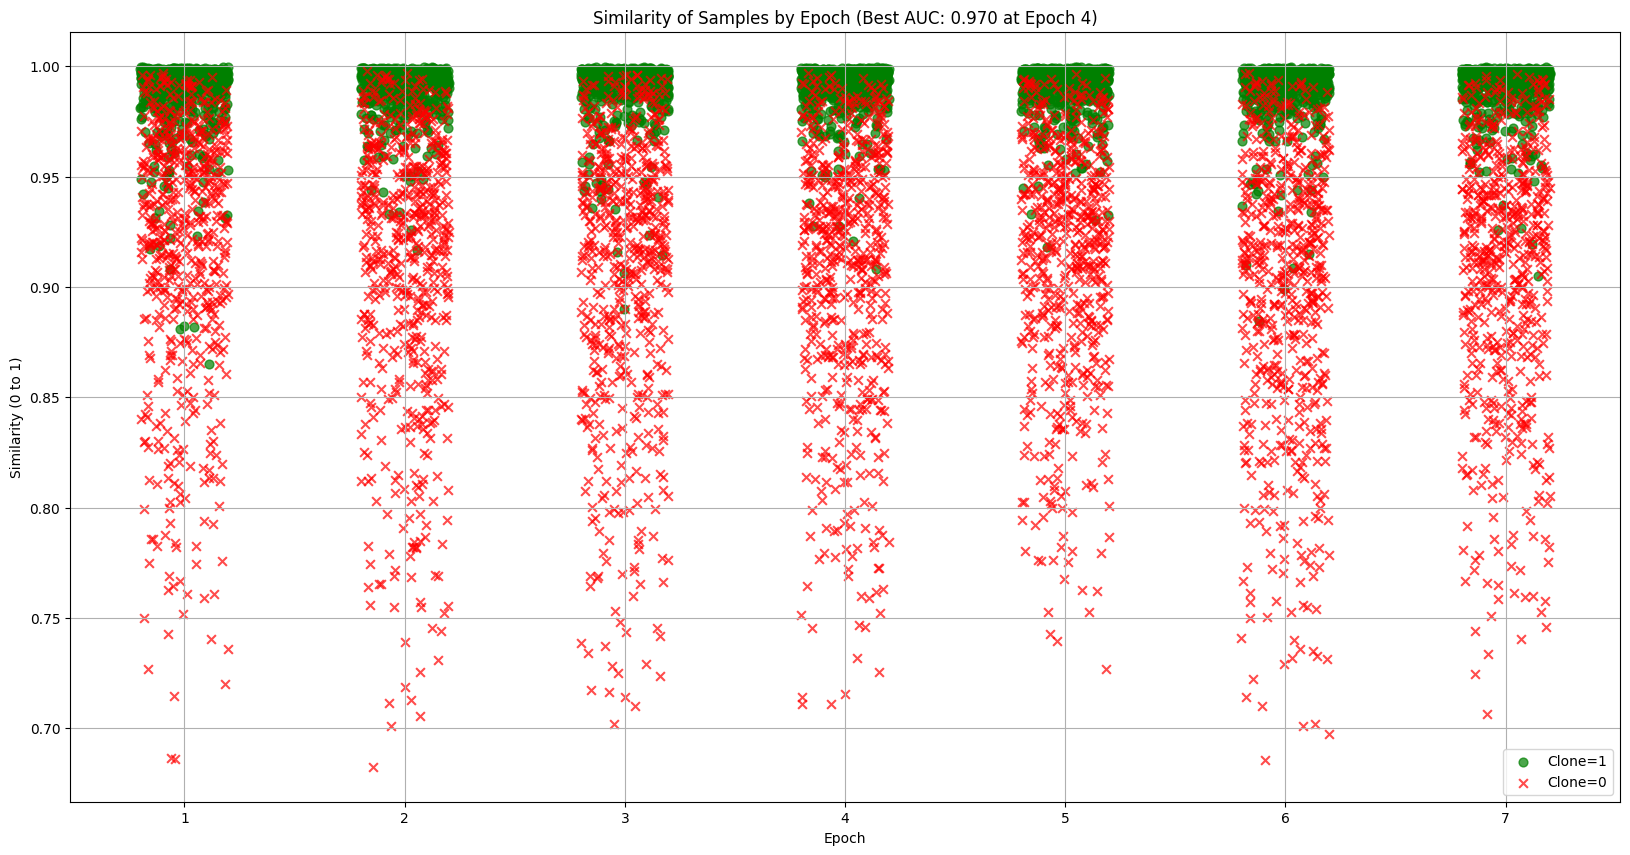

Epoch 8:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10421942189823125

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


val Loss: 0.0871 AUC 0.9711985874532613



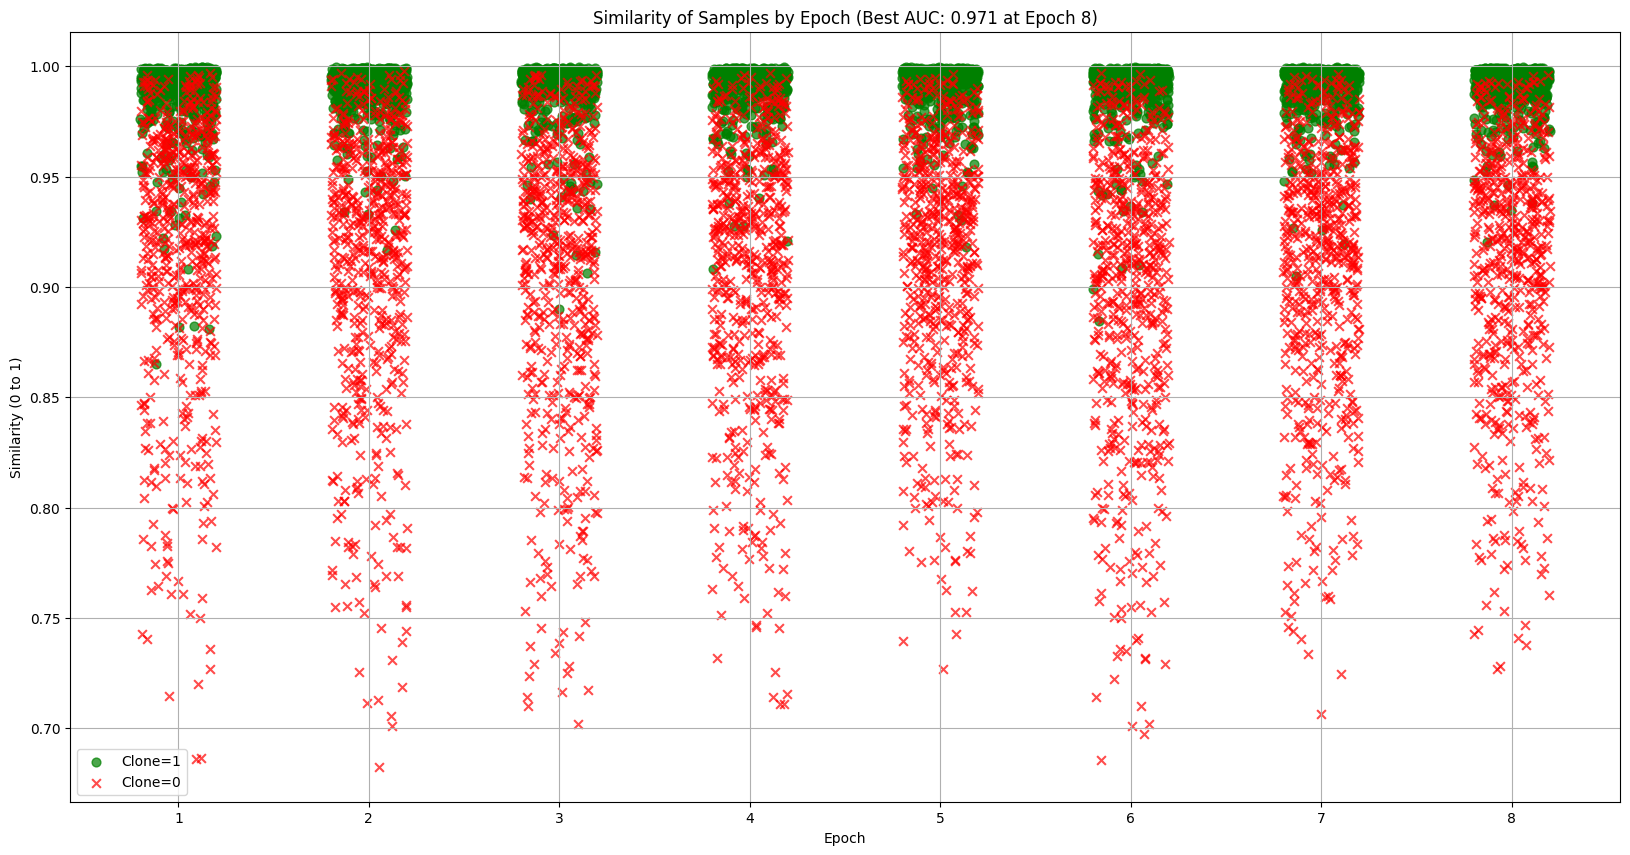

Epoch 9:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10270747984799583

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


val Loss: 0.0925 AUC 0.968967001008962



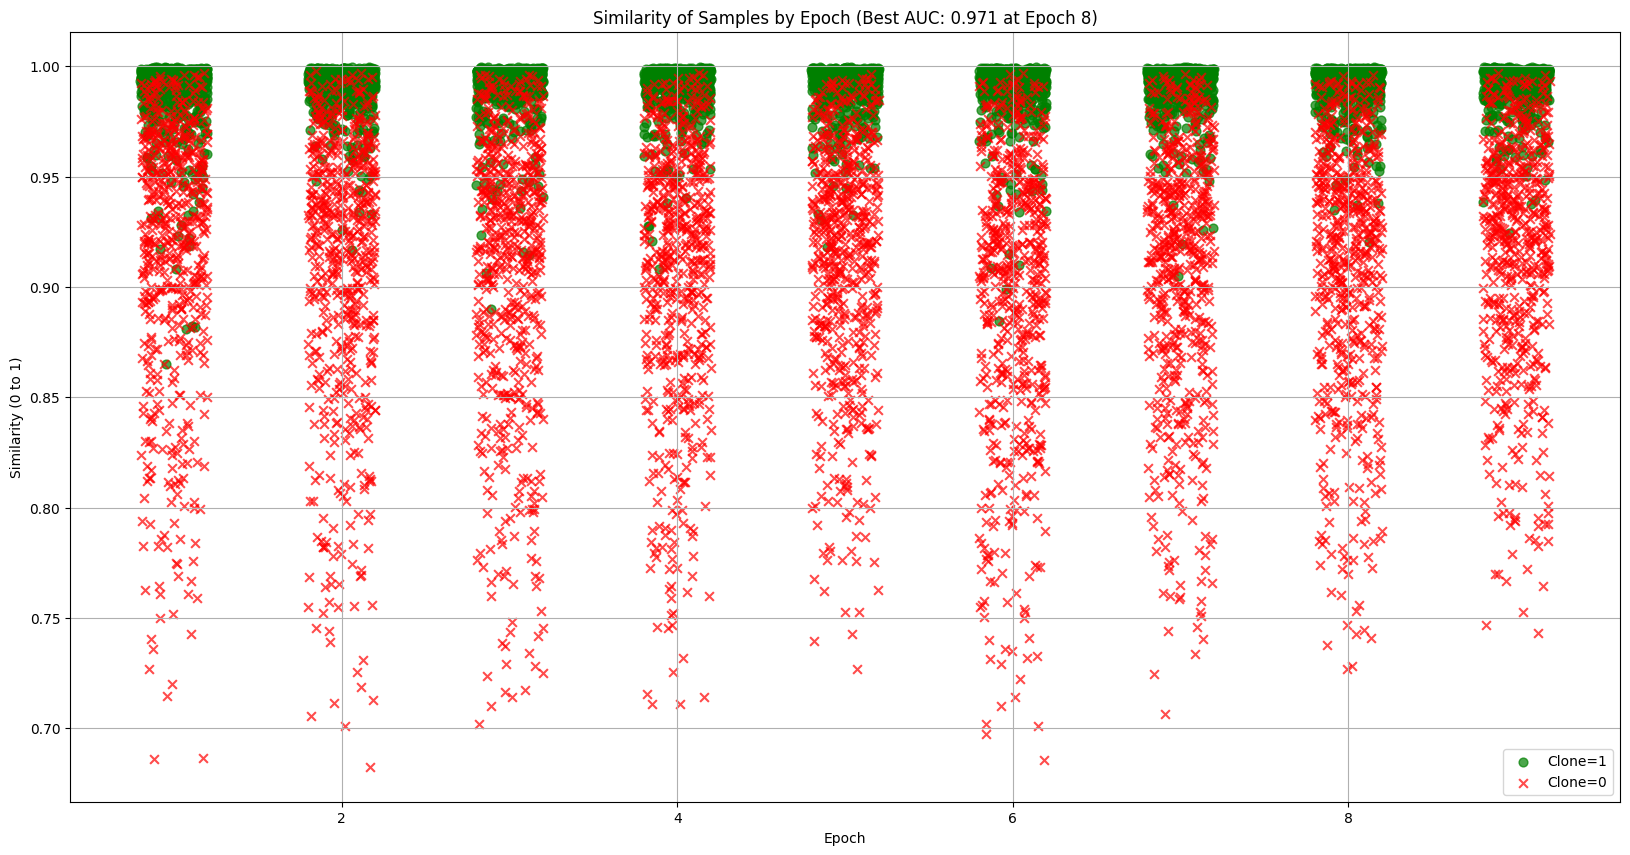

Epoch 10:


Training: 100%|██████████| 581/581 [03:40<00:00,  2.64it/s]


training loss 0.10205621173582881

Evaluating on validation set...


Validation: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]


saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model
val Loss: 0.0846 AUC 0.9723974716600392



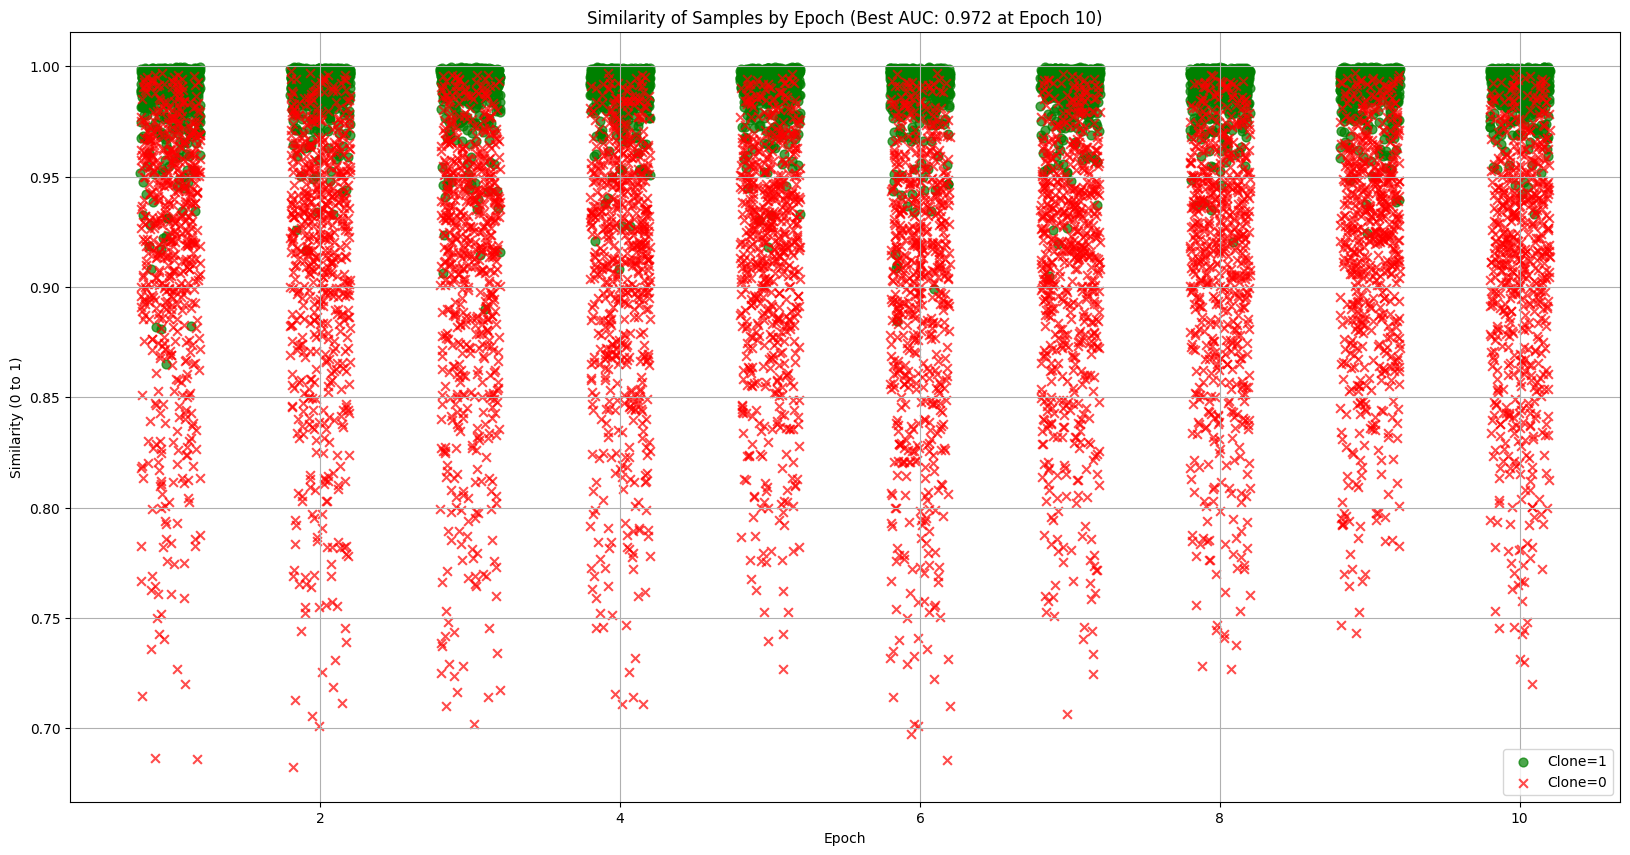

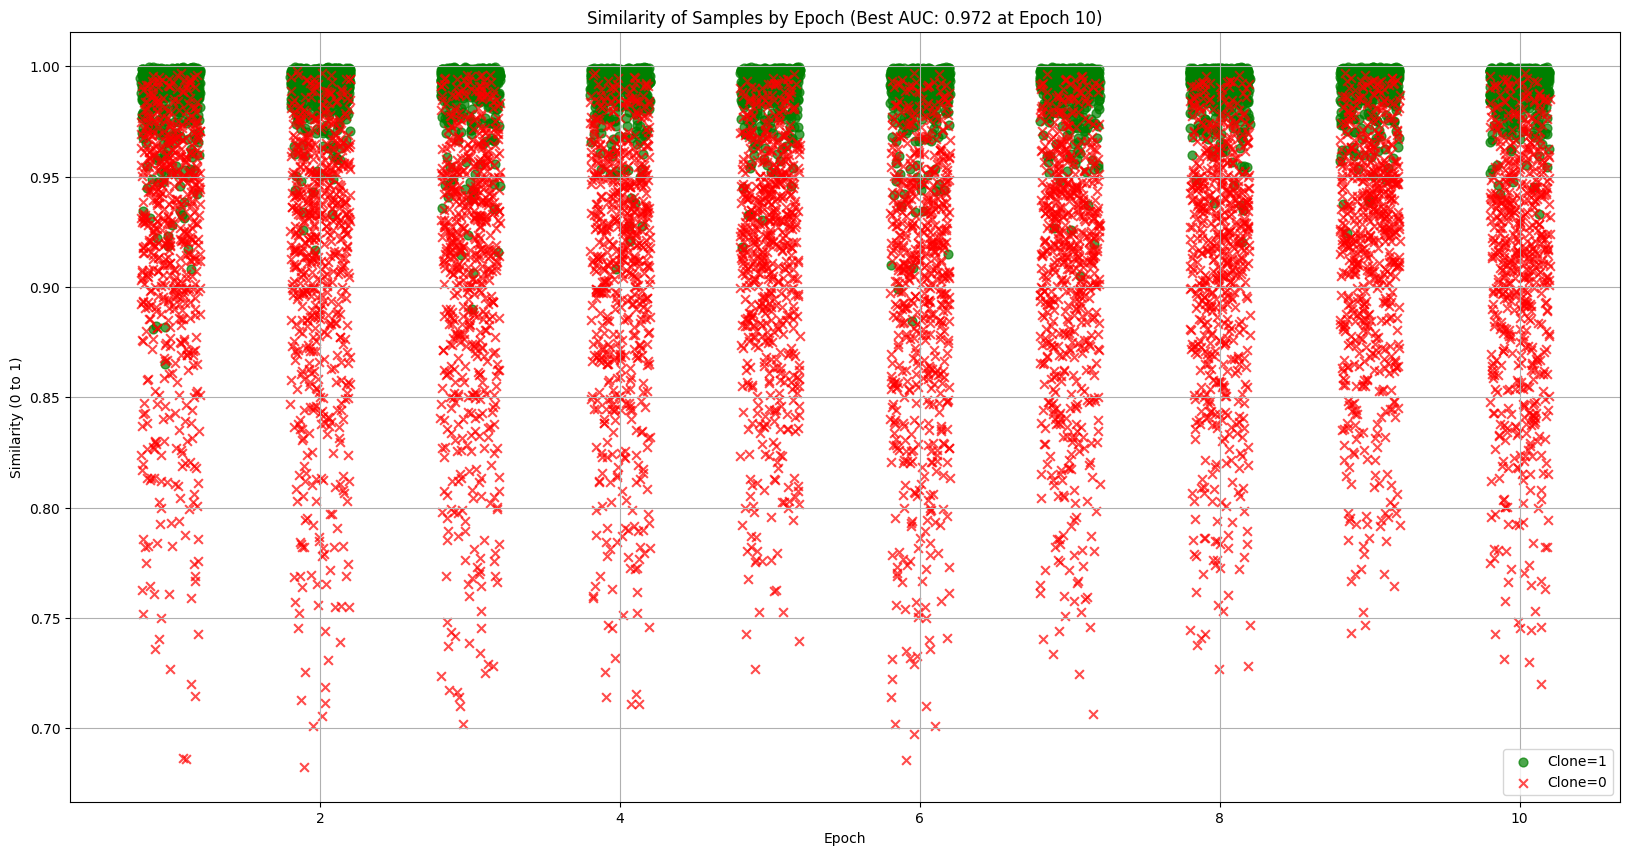

saving best model
Model saved successfully to Google Drive at: /content/drive/MyDrive/saved_model


In [ ]:
model, tokenizer ,history , similarity_data = start_training(load_trained_model = False)


In [ ]:
import json

# Directory path
DIR = "/content/drive/MyDrive/GptCloneDataset/res"

# Assuming similarity_data is a list of dictionaries
for i in range(len(similarity_data)):
    # Create a file path for each dictionary
    file_path = f"{DIR}/similarity_data{i}.json"

    # Save each dictionary as a JSON file
    with open(file_path, "w") as json_file:
        similarity_data[i]['label'] = similarity_data[i]['label'].item()
        json.dump(similarity_data[i], json_file, indent=4)

    # Inform about the saved file
    print(f"Dictionary saved to {file_path}")


Streaming output truncated to the last 5000 lines.
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6610.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6611.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6612.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6613.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6614.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6615.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6616.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6617.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6618.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/similarity_data6619.json
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/res/simila

In [ ]:
similarity_data

[{'epoch': 1, 'similarity': 0.9116907119750977, 'label': 0},
 {'epoch': 1, 'similarity': 0.9974296689033508, 'label': 1},
 {'epoch': 1, 'similarity': 0.9765176773071289, 'label': 0},
 {'epoch': 1, 'similarity': 0.9676656723022461, 'label': 0},
 {'epoch': 1, 'similarity': 0.9977989196777344, 'label': 1},
 {'epoch': 1, 'similarity': 0.9575561285018921, 'label': 1},
 {'epoch': 1, 'similarity': 0.8955267667770386, 'label': 0},
 {'epoch': 1, 'similarity': 0.997685432434082, 'label': 1},
 {'epoch': 1, 'similarity': 0.7267865538597107, 'label': 0},
 {'epoch': 1, 'similarity': 0.9793062806129456, 'label': 1},
 {'epoch': 1, 'similarity': 0.997012734413147, 'label': 1},
 {'epoch': 1, 'similarity': 0.9028451442718506, 'label': 0},
 {'epoch': 1, 'similarity': 0.9994134902954102, 'label': 1},
 {'epoch': 1, 'similarity': 0.9039081335067749, 'label': 0},
 {'epoch': 1, 'similarity': 0.8944166302680969, 'label': 0},
 {'epoch': 1, 'similarity': 0.9490842819213867, 'label': 1},
 {'epoch': 1, 'similarity'

In [ ]:
similarity_data

[{'epoch': 1, 'similarity': 0.9116907119750977, 'label': 0},
 {'epoch': 1, 'similarity': 0.9974296689033508, 'label': 1},
 {'epoch': 1, 'similarity': 0.9765176773071289, 'label': 0},
 {'epoch': 1, 'similarity': 0.9676656723022461, 'label': 0},
 {'epoch': 1, 'similarity': 0.9977989196777344, 'label': 1},
 {'epoch': 1, 'similarity': 0.9575561285018921, 'label': 1},
 {'epoch': 1, 'similarity': 0.8955267667770386, 'label': 0},
 {'epoch': 1, 'similarity': 0.997685432434082, 'label': 1},
 {'epoch': 1, 'similarity': 0.7267865538597107, 'label': 0},
 {'epoch': 1, 'similarity': 0.9793062806129456, 'label': 1},
 {'epoch': 1, 'similarity': 0.997012734413147, 'label': 1},
 {'epoch': 1, 'similarity': 0.9028451442718506, 'label': 0},
 {'epoch': 1, 'similarity': 0.9994134902954102, 'label': 1},
 {'epoch': 1, 'similarity': 0.9039081335067749, 'label': 0},
 {'epoch': 1, 'similarity': 0.8944166302680969, 'label': 0},
 {'epoch': 1, 'similarity': 0.9490842819213867, 'label': 1},
 {'epoch': 1, 'similarity'

In [ ]:
plot_similarity_scatter(similarity_data)


AttributeError: 'int' object has no attribute 'item'

df loaded with 23230 rows and Index(['function 1', 'function 2', 'clone'], dtype='object') columns
working with cuda


Testing: 100%|██████████| 28/28 [01:51<00:00,  3.98s/it]


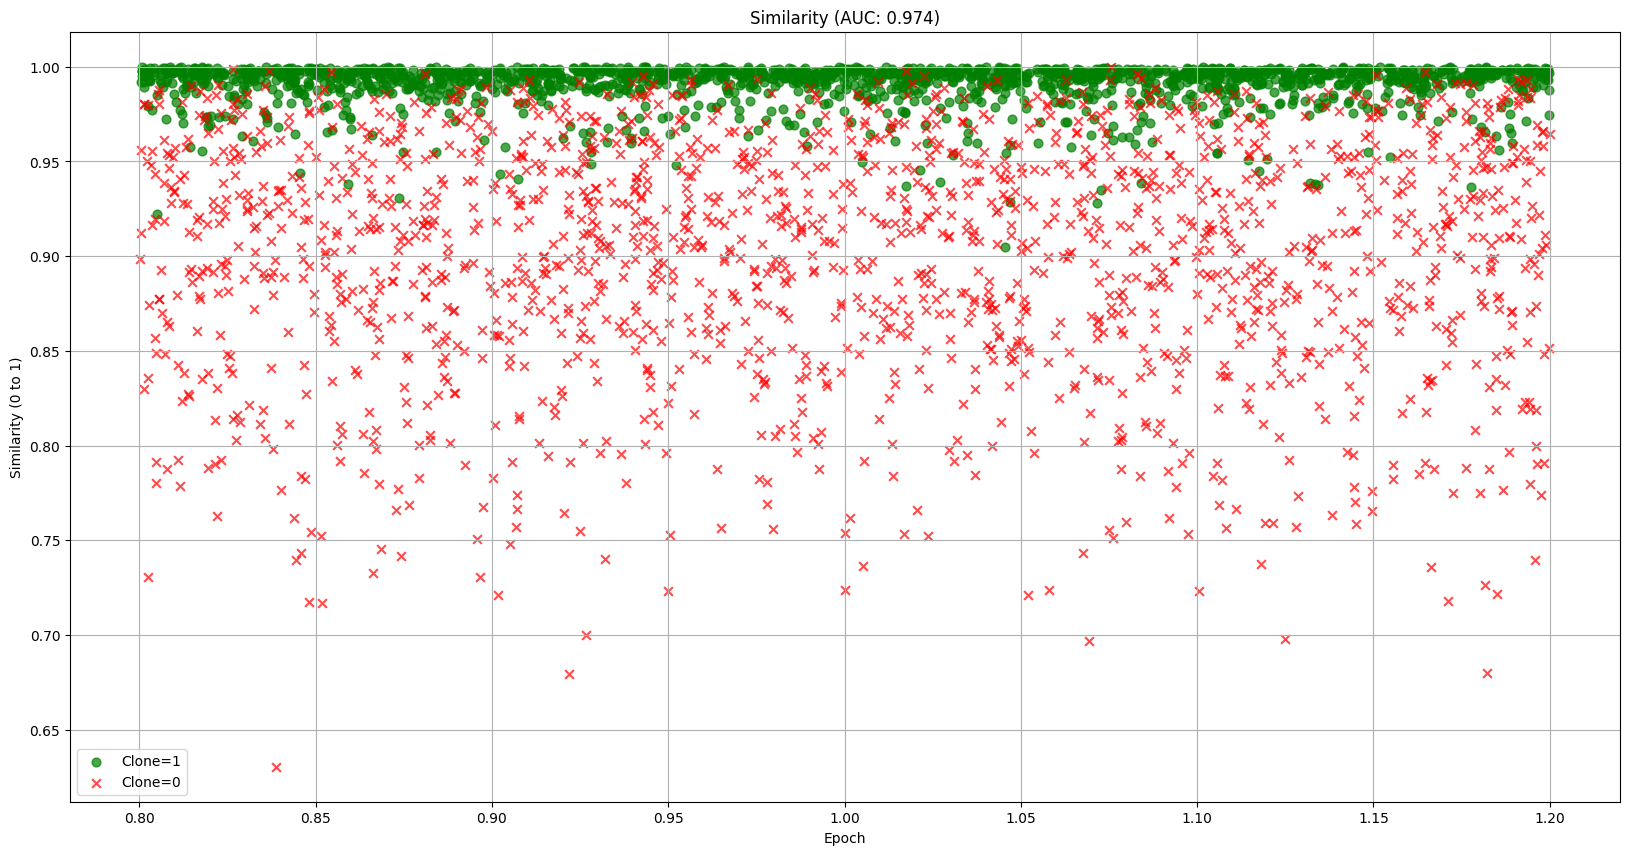

In [ ]:
def start_testing(model):
    Traindataloader,validationDataloader, Testdataloader  = get_dataloaders(
        batch_size=128,
        num_workers=16
    )

    print("working with cuda") if torch.cuda.is_available() else print("working with cpu")
    similarity_data = test_model(
        model,
        Testdataloader,
        device,

    )
    # Save the model after training
    return similarity_data
similarity_data_test = start_testing(model)


In [ ]:
import json

# Directory path
DIR = "/content/drive/MyDrive/GptCloneDataset/testres"

# Assuming similarity_data is a list of dictionaries
for i in range(len(similarity_data_test)):
    # Create a file path for each dictionary
    file_path = f"{DIR}/similarity_data{i}.json"

    # Save each dictionary as a JSON file
    with open(file_path, "w") as json_file:
        print(similarity_data_test[i])
        similarity_data_test[i]['label'] = similarity_data_test[i]['label'].item()
        json.dump(similarity_data_test[i], json_file, indent=4)

    # Inform about the saved file
    print(f"Dictionary saved to {file_path}")


Streaming output truncated to the last 5000 lines.
{'similarity': 0.9840756058692932, 'label': tensor(1)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data985.json
{'similarity': 0.9862313270568848, 'label': tensor(1)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data986.json
{'similarity': 0.9885773658752441, 'label': tensor(1)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data987.json
{'similarity': 0.945059061050415, 'label': tensor(1)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data988.json
{'similarity': 0.9240455627441406, 'label': tensor(0)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data989.json
{'similarity': 0.9996349215507507, 'label': tensor(1)}
Dictionary saved to /content/drive/MyDrive/GptCloneDataset/testres/similarity_data990.json
{'similarity': 0.8812884092330933, 'label': tensor(0)}
Dictionary saved to

test AUC


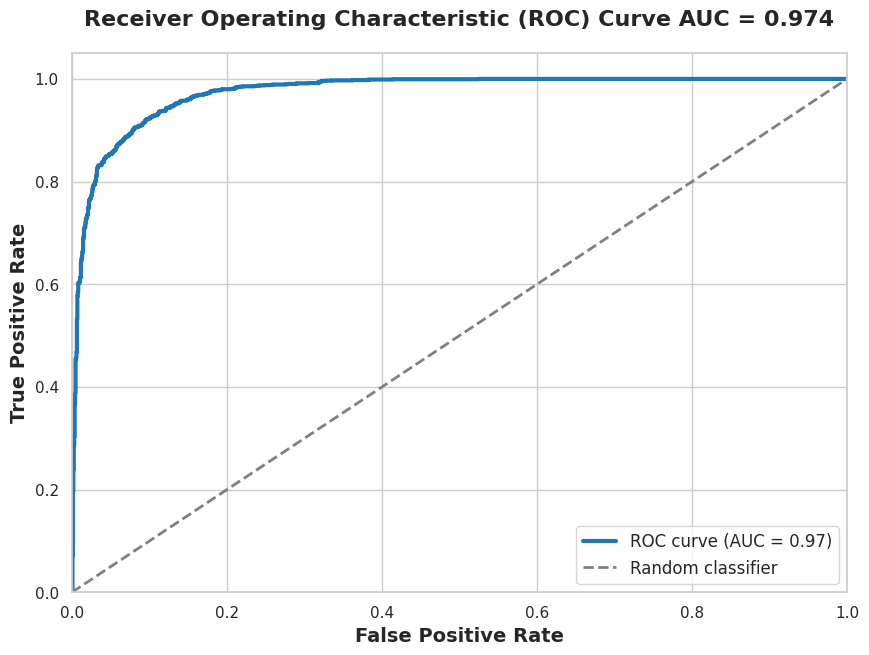

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def plot_roc_curve(similarity_data):
    # Convert data to a DataFrame for easier processing
    df = pd.DataFrame(similarity_data)

    # Extract true labels and similarity scores
    y_true = [f for f in df['label']]  # Ground truth
    y_scores = df['similarity']  # Predicted scores

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)  # Compute the Area Under the Curve (AUC)

    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    sns.set_theme(style="whitegrid")  # Use Seaborn for better aesthetics

    # Main ROC curve
    plt.plot(fpr, tpr, color='#1f77b4', lw=3, label=f"ROC curve (AUC = {roc_auc:.2f})")

    # Random classifier line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random classifier")

    # Set limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
    plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve AUC = {round(roc_auc,4)}", fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=12)

    # Show the plot
    plt.show()


plot_roc_curve(similarity_data_test)


In [ ]:
loaded_model, loaded_tokenizer, config = load_model('saved_model')
predictor = CodeClonePredictor(loaded_model, loaded_tokenizer)

# Compare two code snippets
code1 = '''
int main (int argc, char **argv) {
    int tree1 = 14;
    int tree2 = 7;
    int tree3 = 16;
    int limit = 11;
    int cutamounttotal = 0;
    cutamounttotal += CUTAMOUNT (tree1, limit);
    cutamounttotal += CUTAMOUNT (tree2, limit);
    cutamounttotal += CUTAMOUNT (tree3, limit);
    printf ("Amount to remove: %d\n", cutamounttotal);
    return 0;
}
'''

code2 = '''
int main () {
=    cutamounttotal += CUTAMOUNT (tree3, limit);
    printf ("Amount to remove: %d\n", cutamounttotal);
    return 0;
}
'''

similarity = predictor.compare_codes(code1, code2)
print(f"Similarity score: {similarity:.3f}")



In [ ]:
code3 = '''
jshdjgdskhglkshdljgksd}
'''

similarity = predictor.compare_codes(code1, code3)
print(f"Similarity score: {similarity:.3f}")

In [ ]:
# Find clones in a list of codes
code_list = [ code2, "other code snippets...", "public class Fibonacci {"]
clones = predictor.find_clones(code1, code_list, threshold=0.98)

for clone in clones:
    print(f"Clone found with similarity: {clone['similarity']:.3f}")
    print("Code:")
    print(clone['code'])
    print("-" * 50)
